In [2]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.1 MB/s eta 0:00:000:00:01


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

In [5]:
from torch_geometric.datasets import TUDataset, GNNBenchmarkDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric.transforms import RandomNodeSplit

from torch_geometric.nn import Sequential, GCNConv, global_mean_pool
from torch.nn import Dropout, Linear, ReLU, Sigmoid

#from torchmetrics.functional import accuracy, precision_recall, confusion_matrix
import torch
import torch.nn.functional as F

In [6]:
edges_dataset = pd.read_pickle('elliptic_bitcoin_dataset/elliptic_txs_edgelist_transformed.pkl', )
features_dataset = pd.read_pickle('elliptic_bitcoin_dataset/elliptic_txs_features_light.pkl')
classes_dataset = pd.read_pickle('elliptic_bitcoin_dataset/elliptic_txs_classes_transformed.pkl')

In [8]:
edges_dataset

,txId1,txId2
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9
...,...,...
234350,203602,201430
234351,203603,203099
234352,201921,202042
234353,201480,201368


In [7]:
edges_dataset.shape, features_dataset.shape, classes_dataset.shape

((234355, 2), (203769, 94), (203769, 2))

In [9]:
classes_dataset

,txId,class
0,230425980,NaN
1,5530458,NaN
2,232022460,NaN
3,232438397,1.0
4,230460314,NaN
...,...,...
203764,173077460,NaN
203765,158577750,NaN
203766,158375402,0.0
203767,158654197,NaN


In [37]:
edges_index_tensor = torch.tensor(edges_dataset.T.to_numpy(), dtype=torch.long)
features_tensor = torch.tensor(features_dataset.to_numpy()[:,1:], dtype=torch.float)
y_labels_tensor = torch.tensor(classes_dataset.to_numpy()[:,1], dtype=torch.int)
y_labels_tensor[y_labels_tensor < 0] = -1

edges_index_tensor.size(), features_tensor.size(), y_labels_tensor.size()

(torch.Size([2, 234355]), torch.Size([203769, 93]), torch.Size([203769]))

In [38]:
# labelled data mask
y_labelled_mask = y_labels_tensor >= 0

# building the Data graph
bitcoin_graph_data = Data(x=features_tensor, edge_index=edges_index_tensor, y=y_labels_tensor, labelled_mask=y_labelled_mask) 

spliter = RandomNodeSplit(split='train_rest',
                num_val=0,
                num_test=0.6
               )

bitcoin_graph_data = spliter(bitcoin_graph_data)

In [39]:
weight_label = torch.clone(y_labels_tensor).float()
ratio_illicit_to_licit_transactions = (y_labels_tensor==1).sum() / (y_labels_tensor==0).sum()

weight_label[y_labels_tensor==1] = torch.tensor(1)
weight_label[y_labels_tensor==0] = ratio_illicit_to_licit_transactions

In [56]:
class BitcoinGCN(torch.nn.Module):
    def __init__(self, n_features, latent_layer_1=64, latent_layer_2=32):
        super().__init__()
        """ GCNConv layers """
        self.latent_layer_1 = latent_layer_1
        self.latent_layer_2 = latent_layer_2
        
        self.n_features = n_features
        
        self.model = Sequential("x, edge_index",
                                [
                                    (GCNConv(self.n_features, self.latent_layer_1), "x, edge_index -> h1"),
                                    (ReLU(), "h1 -> r1"),
                                    (Dropout(p=0.2), "r1 -> d1"),
                                    (GCNConv(self.latent_layer_1, self.latent_layer_2), "d1, edge_index -> h2"),
                                    (ReLU(), "h2 -> r2"),
                                    (Dropout(p=0.2), "r2 -> d2"),
                                    (Linear(self.latent_layer_2, 1), "d2 -> a3"),
                                    (Sigmoid(), "a3 -> x_output")
                                ]
                               )
        #self.conv1 = GCNConv(self.n_features, self.latent_layer_1)
        #self.relu1 = ReLU()
        #self.dropout1 = Dropout(p=0.2)
        
        #self.conv2 = GCNConv(self.latent_layer_1, self.latent_layer_2)
        
        #self.layer_out = Linear(self.latent_layer_2, 1) 
        #self.sigmoid = Sigmoid()
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                                
        x_output = self.model(x, edge_index)
        #x = self.conv1(x, edge_index)
        #x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        #x = self.conv2(x, edge_index)

        return x_output #self.sigmoid(x)

### Adding or not the weights
By adding the weights on the illicit class (`y=0`), we force the model to aggressively flag the illicit examples. This results in a **high recall, low precision** overall predictive capability. On the order hand, no weights will result in a **low recall, high precision** model.

The decision process on the balance between precision and recall would be made knowing if we are looking to automate the tagging of illicit transactions (high precision needed), or if we plan to have people review the flagged transactions and label them correctly (high recall required).

In [86]:
# prepping masks
training_labelled_mask = bitcoin_graph_data.labelled_mask & bitcoin_graph_data.train_mask
test_labelled_mask = bitcoin_graph_data.labelled_mask & bitcoin_graph_data.test_mask

model = BitcoinGCN(bitcoin_graph_data.num_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_function = torch.nn.BCELoss(reduction='mean')#, weight=weight_label[training_labelled_mask])

In [87]:
# train the model
model.train()
losses = []
train_accuracies = []
test_accuracies = []
precisions = []
recalls = []

print('Epoch','Loss','Tr_Acc','Test_Acc','Precision','Recall', sep='\t')

for epoch in range(200):

    # training
    optimizer.zero_grad()
    out = model(bitcoin_graph_data).view(-1) # flatten
    
    loss = loss_function(out[training_labelled_mask], 
                         bitcoin_graph_data.y[training_labelled_mask].float(),
                        )
    
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # evaluation metrics
    train_accuracy = accuracy(out[training_labelled_mask], 
                              bitcoin_graph_data.y[training_labelled_mask],
                              average='none', 
                              num_classes=2, 
                              multiclass=True
                             )
    test_accuracy = accuracy(out[test_labelled_mask], 
                             bitcoin_graph_data.y[test_labelled_mask],
                             average='none', 
                             num_classes=2, 
                             multiclass=True
                            )
        
    precision, recall = precision_recall(out[test_labelled_mask].round(), 
                                         bitcoin_graph_data.y[test_labelled_mask], 
                                         average='none', 
                                         num_classes=2, 
                                         multiclass=True)
    
    # take first element of each eval metric to get the metric of class 0 (illicit transactions)
    train_accuracies.append(train_accuracy[0])
    test_accuracies.append(test_accuracy[0])
    precisions.append(precision[0])
    recalls.append(recall[0])
    
    if (epoch+1) % 20 == 0:
        print(epoch+1, 
              "{:.2f}".format(loss.item()), 
              "{:.2f}".format(train_accuracy[0].item()), 
              "{:.2f}".format(test_accuracy[0].item()), 
              "{:.2f}".format(precision[0].item()), 
              "{:.2f}".format(recall[0].item()),
              sep='\t')

    # early stopping
    if len(losses) > 20:
        if np.mean(losses[-4:]) > np.mean(losses[-5:-1]): # little moving average on 4 consecutive epochs to be sure it's globally goign up
            print('\nEarly stopping')
            print(epoch+1, "{:.2f}".format(loss.item()), train_accuracy[0], test_accuracy[0], precision[0], recall[0], sep='\t')
            break

Epoch	Loss	Tr_Acc	Test_Acc	Precision	Recall
20	0.25	0.02	0.03	0.62	0.03
40	0.22	0.11	0.10	0.82	0.10

Early stopping
43	0.21	tensor(0.1248)	tensor(0.1291)	tensor(0.8561)	tensor(0.1291)


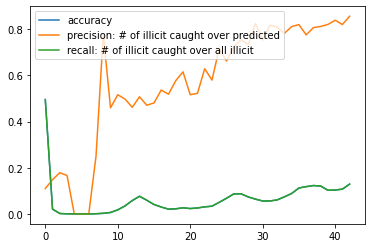

In [88]:
import matplotlib.pyplot as plt
#plt.plot(losses,label='loss')
plt.plot(test_accuracies,label='accuracy')
plt.plot(precisions,label='precision: # of illicit caught over predicted')
plt.plot(recalls, label='recall: # of illicit caught over all illicit')
plt.legend()
plt.show()

In [89]:
model.eval()
with torch.no_grad():
    out = model(bitcoin_graph_data).view(-1) # flatten
    unknown_label_predictions = out[~bitcoin_graph_data.labelled_mask].clone().round()

In [107]:
print("Percentage of illicit transactions caught in unlabelled data: %.2f %%" % float(100*(1 - unknown_label_predictions).mean().item()))
print("Percentage of illicit transactions present in labelled data:  %.2f %%" % float(bitcoin_graph_data.y[y_labelled_mask].float().mean().item()))

Percentage of illicit transactions caught in unlabelled data: 2.93 %
Percentage of illicit transactions present in labelled data:  0.90 %
